In [105]:
dafiCase = '../case-1/'
sampleId = 50
timeDir = 100

In [106]:
###################################################################
# load data
#############################################################################
# plot flow field
import os
import numpy as np
import fluidfoam as ff

##############################################################################
foamCase = os.path.join(dafiCase, 'results_ensemble', f'sample_{sampleId}')
U = ff.readvector(foamCase, f'{timeDir:g}', 'U')
theta1 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta1')
theta2 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta2')
theta3 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta3')
theta4 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta4')
theta5 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta5')
theta6 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta6')
g1 = ff.readscalar(foamCase, f'{timeDir:g}', 'g1')
g2 = ff.readscalar(foamCase, f'{timeDir:g}', 'g2')
g3 = ff.readscalar(foamCase, f'{timeDir:g}', 'g3')
g4 = ff.readscalar(foamCase, f'{timeDir:g}', 'g4')
print('Ux, min, max', U[0, :].min(), U[0, :].max())
print('Uy, min, max', U[1, :].min(), U[1, :].max())
print('Uz, min, max', U[2, :].min(), U[2, :].max())
print('theta1, min, max', theta1.min(), theta1.max())
print('theta2, min, max', theta2.min(), theta2.max())
print('theta3, min, max', theta3.min(), theta3.max())
print('theta4, min, max', theta4.min(), theta4.max())
print('theta5, min, max', theta5.min(), theta5.max())
print('theta6, min, max', theta6.min(), theta6.max())
x, y, z = ff.readmesh(foamCase)

theta = np.concatenate(
    (theta1.reshape(-1, 1), theta2.reshape(-1, 1), theta3.reshape(-1, 1),
     theta4.reshape(-1, 1), theta5.reshape(-1, 1), theta6.reshape(-1, 1)),
    axis=1)

g = np.concatenate(
    (g1.reshape(-1, 1), g2.reshape(-1, 1), g3.reshape(-1, 1), g4.reshape(
        -1, 1)),
    axis=1)

np.savetxt(
    'theta-range.csv',
    np.concatenate(
        (theta.min(axis=0).reshape(-1, 1), theta.max(axis=0).reshape(-1, 1)),
        axis=1),
    delimiter=',')

Reading file ../case-1/results_ensemble/sample_50/100/U
Reading file ../case-1/results_ensemble/sample_50/100/theta1
Reading file ../case-1/results_ensemble/sample_50/100/theta2
Reading file ../case-1/results_ensemble/sample_50/100/theta3
Reading file ../case-1/results_ensemble/sample_50/100/theta4
Reading file ../case-1/results_ensemble/sample_50/100/theta5
Reading file ../case-1/results_ensemble/sample_50/100/theta6
Reading file ../case-1/results_ensemble/sample_50/100/g1
Reading file ../case-1/results_ensemble/sample_50/100/g2
Reading file ../case-1/results_ensemble/sample_50/100/g3
Reading file ../case-1/results_ensemble/sample_50/100/g4
Ux, min, max 0.000940639 1.32315
Uy, min, max -0.00129902 0.00181287
Uz, min, max -0.00129902 0.00181287
theta1, min, max 0.00334674 7.52324
theta2, min, max -7.52324 -0.00334674
theta3, min, max -0.20568 0.203749
theta4, min, max -0.0679166 0.0685601
theta5, min, max -28.2996 -5.60033e-06
theta6, min, max -1.4e-14 0.0127022
Reading file ../case-1/

In [133]:
################################################################
# load neural network
import time
import tensorflow as tf
import numpy as np
import os

# set threads of tf = 1
os.environ["TF_NUM_INTEROP_THREADS"] = "1"  #
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"  #
# set threads of openmp = 1
os.environ["OMP_NUM_THREADS"] = "1"  #

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

f = open('python_module.log', 'w+')
print('_________________________________________________________________',
      file=f)
print('Computing function of scalar invariants from Python module', file=f)
print('Tensorflow version', tf.__version__, file=f)
print('_________________________________________________________________',
      file=f)

# tf.keras.backend.clear_session()
# tf.config.threading.set_intra_op_parallelism_threads(2)
# load model

model_path = '../NN-pre-train/nn_model_235.h5'
model = tf.keras.models.load_model(model_path)
# model.summary()

# load weights
# get weights flatten
weights_flatten = np.loadtxt(
    os.path.join(dafiCase, 'results_ensemble', f'sample_{sampleId}',
                 'nn_weights_flatten.dat'))
# weights_flatten = np.loadtxt('/home/wuct/dafi/pehills-NN-closure/inputs/w.0')

# get model shape
shapes = []
for iw in model.trainable_variables:
    shapes.append(iw.shape)

# shapes to sizes
sizes = []
for shape in shapes:
    isize = 1
    for ishape in shape:
        isize *= ishape
    sizes.append(isize)

# reshape weights
w_reshaped = []
i = 0
for shape, size in zip(shapes, sizes):
    w_reshaped.append(weights_flatten[i:i + size].reshape(shape))
    i += size
    # print(w_reshaped)
model.set_weights(w_reshaped)

print(model.get_weights(), file=f)
print('Neural-network weights loaded successfully', file=f)

# load scale tick
# scale_tick = np.loadtxt('/home/wuct/dafi/pehills-NN-closure/NN-PRE-TRAIN/scale_tick.dat')
# print('Load scale tick successfully\n')


def ml_func(array):
    # print(np.shape(array))
    array_scaled = np.zeros_like(array)
    t12 = np.loadtxt('theta-range.csv', delimiter=',')

    array_scaled[:, 0] = (array[:, 0] - t12[0, 0]) / (t12[0, 1] - t12[0, 0])
    array_scaled[:, 1] = (array[:, 1] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 2] = (array[:, 2] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 3] = (array[:, 3] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 4] = (array[:, 4] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 5] = (array[:, 5] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])

    # theta1_min = array[:, 0].min()
    # theta1_max = array[:, 0].max()

    # theta2_min = array[:, 1].min()
    # theta2_max = array[:, 1].max()

    # theta3_min = array[:, 1].min()
    # theta3_max = array[:, 1].max()

    # theta4_min = array[:, 1].min()
    # theta4_max = array[:, 1].max()

    # theta5_min = array[:, 1].min()
    # theta5_max = array[:, 1].max()

    # theta6_min = array[:, 1].min()
    # theta6_max = array[:, 1].max()

    # array_scaled[:, 0] = (array[:, 0] - theta1_min) / (theta1_max - theta1_min)
    # array_scaled[:, 1] = (array[:, 1] - theta2_min) / (theta2_max - theta2_min)
    # array_scaled[:, 2] = (array[:, 2] - theta3_min) / (theta3_max - theta3_min)
    # array_scaled[:, 3] = (array[:, 3] - theta4_min) / (theta4_max - theta4_min)
    # array_scaled[:, 4] = (array[:, 4] - theta5_min) / (theta5_max - theta5_min)
    # array_scaled[:, 5] = (array[:, 5] - theta6_min) / (theta6_max - theta6_min)

    # print(array_scaled.min(axis=1), array_scaled.max(axis=1))

    g_ = model(array_scaled, training=False)

    g = np.array(g_).reshape(-1, 5).astype('double')
    # print(g)
    scale = [1.e-1, 1.e-3, 1.e-3, 1.e-3, 0]  # [0.1,0.001,0.001,0.001]
    init = [-0.09, 0, 0, 0, 0]  # [-0.09,1e-4,1e-4,1e-4]
    for i in range(g.shape[1]):
        # scale[i]*g[:, i] + (1.0 - scale[i])*init[i]
        g[:, i] = scale[i] * g[:, i] + init[i]

    # print(g)

    for i in range(g.shape[0]):
        for j in range(g.shape[1]):
            if j == 0 and g[i, j] > -0.0:
                g[i, j] = -0.0
            # if j == 1 and g[i, j] > 0.01: g[i, j] = 0.01
            # if j == 2 and g[i, j] < -0.01: g[i, j] = -0.01
            # if j == 3 and g[i, j] < -0.01: g[i, j] = -0.01
    # print('using tensorflow time', time.time() - t1)

    return g


def g1_nn(theta_):
    g_ = ml_func(theta_)
    # perturbed_data = g_[:, 0] + np.random.normal(0, 1e-8, np.shape(g_[:, 0]))
    return g_[:, 0]  #+ perturbed_data

In [108]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "Helvetica"
    'figure.dpi': 1000,
    'axes.labelsize': 6,
    'xtick.direction': 'in',
    'xtick.labelsize': 6,
    'xtick.top': True,
    'xtick.major.width': 0.5,
    'ytick.direction': 'in',
    'ytick.labelsize': 6,
    'ytick.right': True,
    'ytick.major.width': 0.5,
    'legend.fontsize': 6,
    'axes.linewidth': 0.5,
    'axes.titlesize': 6,
    'grid.linewidth': 0.5
})

In [119]:
###################################################################
# plot predictions
plotStyleNN = {
    'linestyle': 'none',
    'marker': '.',
    'color': 'dodgerblue',
    'markersize': 4,
    'markeredgewidth': 0.5,
    'markerfacecolor': 'none',
    'alpha': 0.5
}
plotStyleShih = {
    'linestyle': 'none',
    'marker': '.',
    'color': 'gray',
    'markersize': 2,
    'markeredgecolor': 'none',
    # 'markerfacecolor': 'none',
    'alpha': 0.5
}

In [110]:
def g1_SHIH(theta_):
    if (theta_[:, 0] < 0).any():
        print('x1 need be larger than zero')
        return
    if (theta_[:, 1] > 0).any():
        print('x2 need be less than zero')
        return
    return -(2.0 / 3.0) / (1.25 + np.sqrt(2 * theta_[:, 0]) +
                           0.9 * np.sqrt(-2 * theta_[:, 1]))


In [137]:
import random
import matplotlib.pyplot as plt

#####################################################################
# process data to avoid inputs' value concentration
press_value = [0, 0, 0, 0, 0, 0]
press_width = [0, 0, 1.e-5, 1.e-5, 0, 1.e-3]

# thetaSampled = theta[randomId, :]

indices_all = [
    np.where(np.abs(theta[:, 0] - press_value[0]) > (press_width[0] * 2)),
    np.where(np.abs(theta[:, 1] - press_value[1]) > (press_width[1] * 2)),
    np.where(np.abs(theta[:, 2] - press_value[2]) > (press_width[2] * 2)),
    np.where(np.abs(theta[:, 3] - press_value[3]) > (press_width[3] * 2)),
    np.where(np.abs(theta[:, 4] - press_value[4]) > (press_width[4] * 2)),
    np.where(np.abs(theta[:, 5] - press_value[5]) > (press_width[5] * 2))
]
indices = indices_all[0]
for arr in indices_all[1:]:
    indices = np.intersect1d(indices, arr)

# thetaUseful = theta[indices, :]
# randomId = random.sample(range(np.shape(thetaUseful)[0]), 501)

fig, ax = plt.subplots(1, 6, figsize=(6, 2))
for i in range(6):
    ax[i].ticklabel_format(style='sci', scilimits=(-0, 1))
    ax[i].plot(theta[:, i], g1_SHIH(theta), **plotStyleShih, label='Shih')
    ax[i].plot(theta[:, i], g1_nn(theta), **plotStyleNN, label='NN')
    ax[i].set(xlabel=rf'$\theta_{i+1}$')
    if i > 0: ax[i].set(yticks=([]))
    ax[0].set(ylabel='$g_1$')
    ax[0].legend()

plt.subplots_adjust(left=0.07, right=0.98, wspace=0.1, bottom=0.15)
plt.savefig('shap-sample.png')
plt.close()

Using 2500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 6/2500 [00:02<15:47,  2.63it/s]Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.164e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.883e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.044e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iter

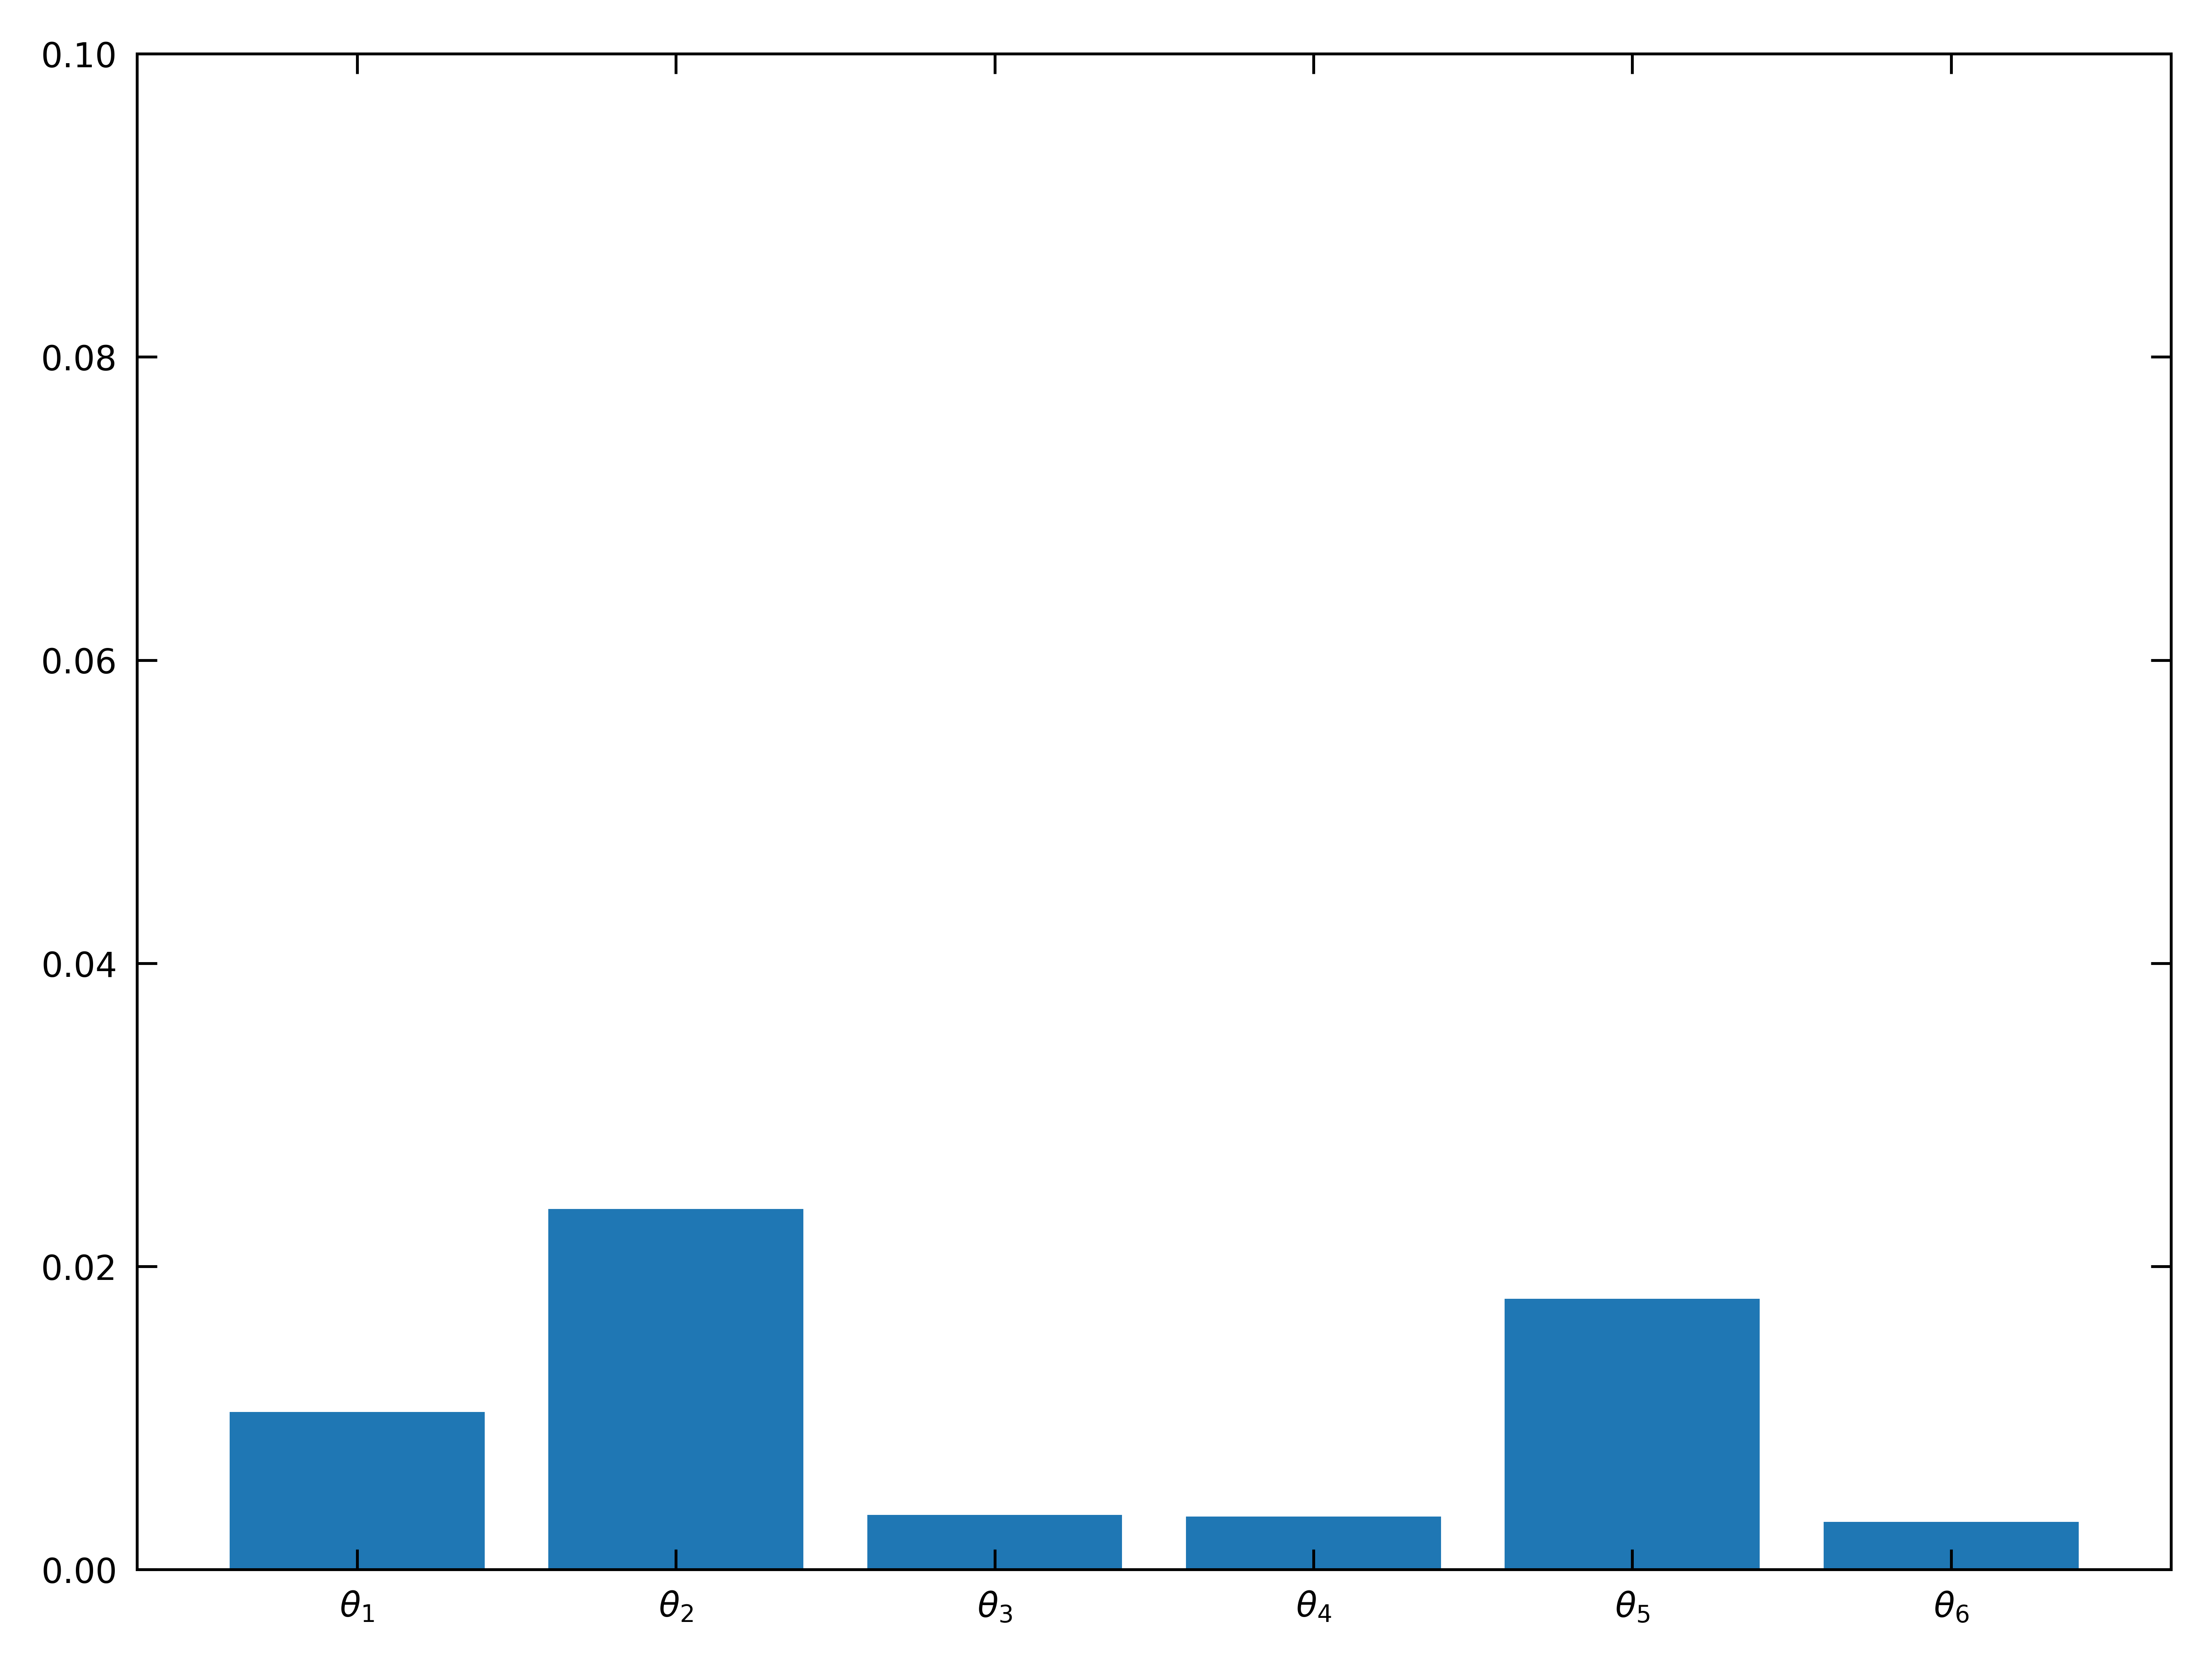

In [138]:
import numpy as np
import shap
import matplotlib.pyplot as plt

explainer = shap.KernelExplainer(g1_nn, theta)
shap_values = explainer.shap_values(theta, nsamples=10)
np.savetxt('SHAP-NN.csv', shap_values, delimiter=',')


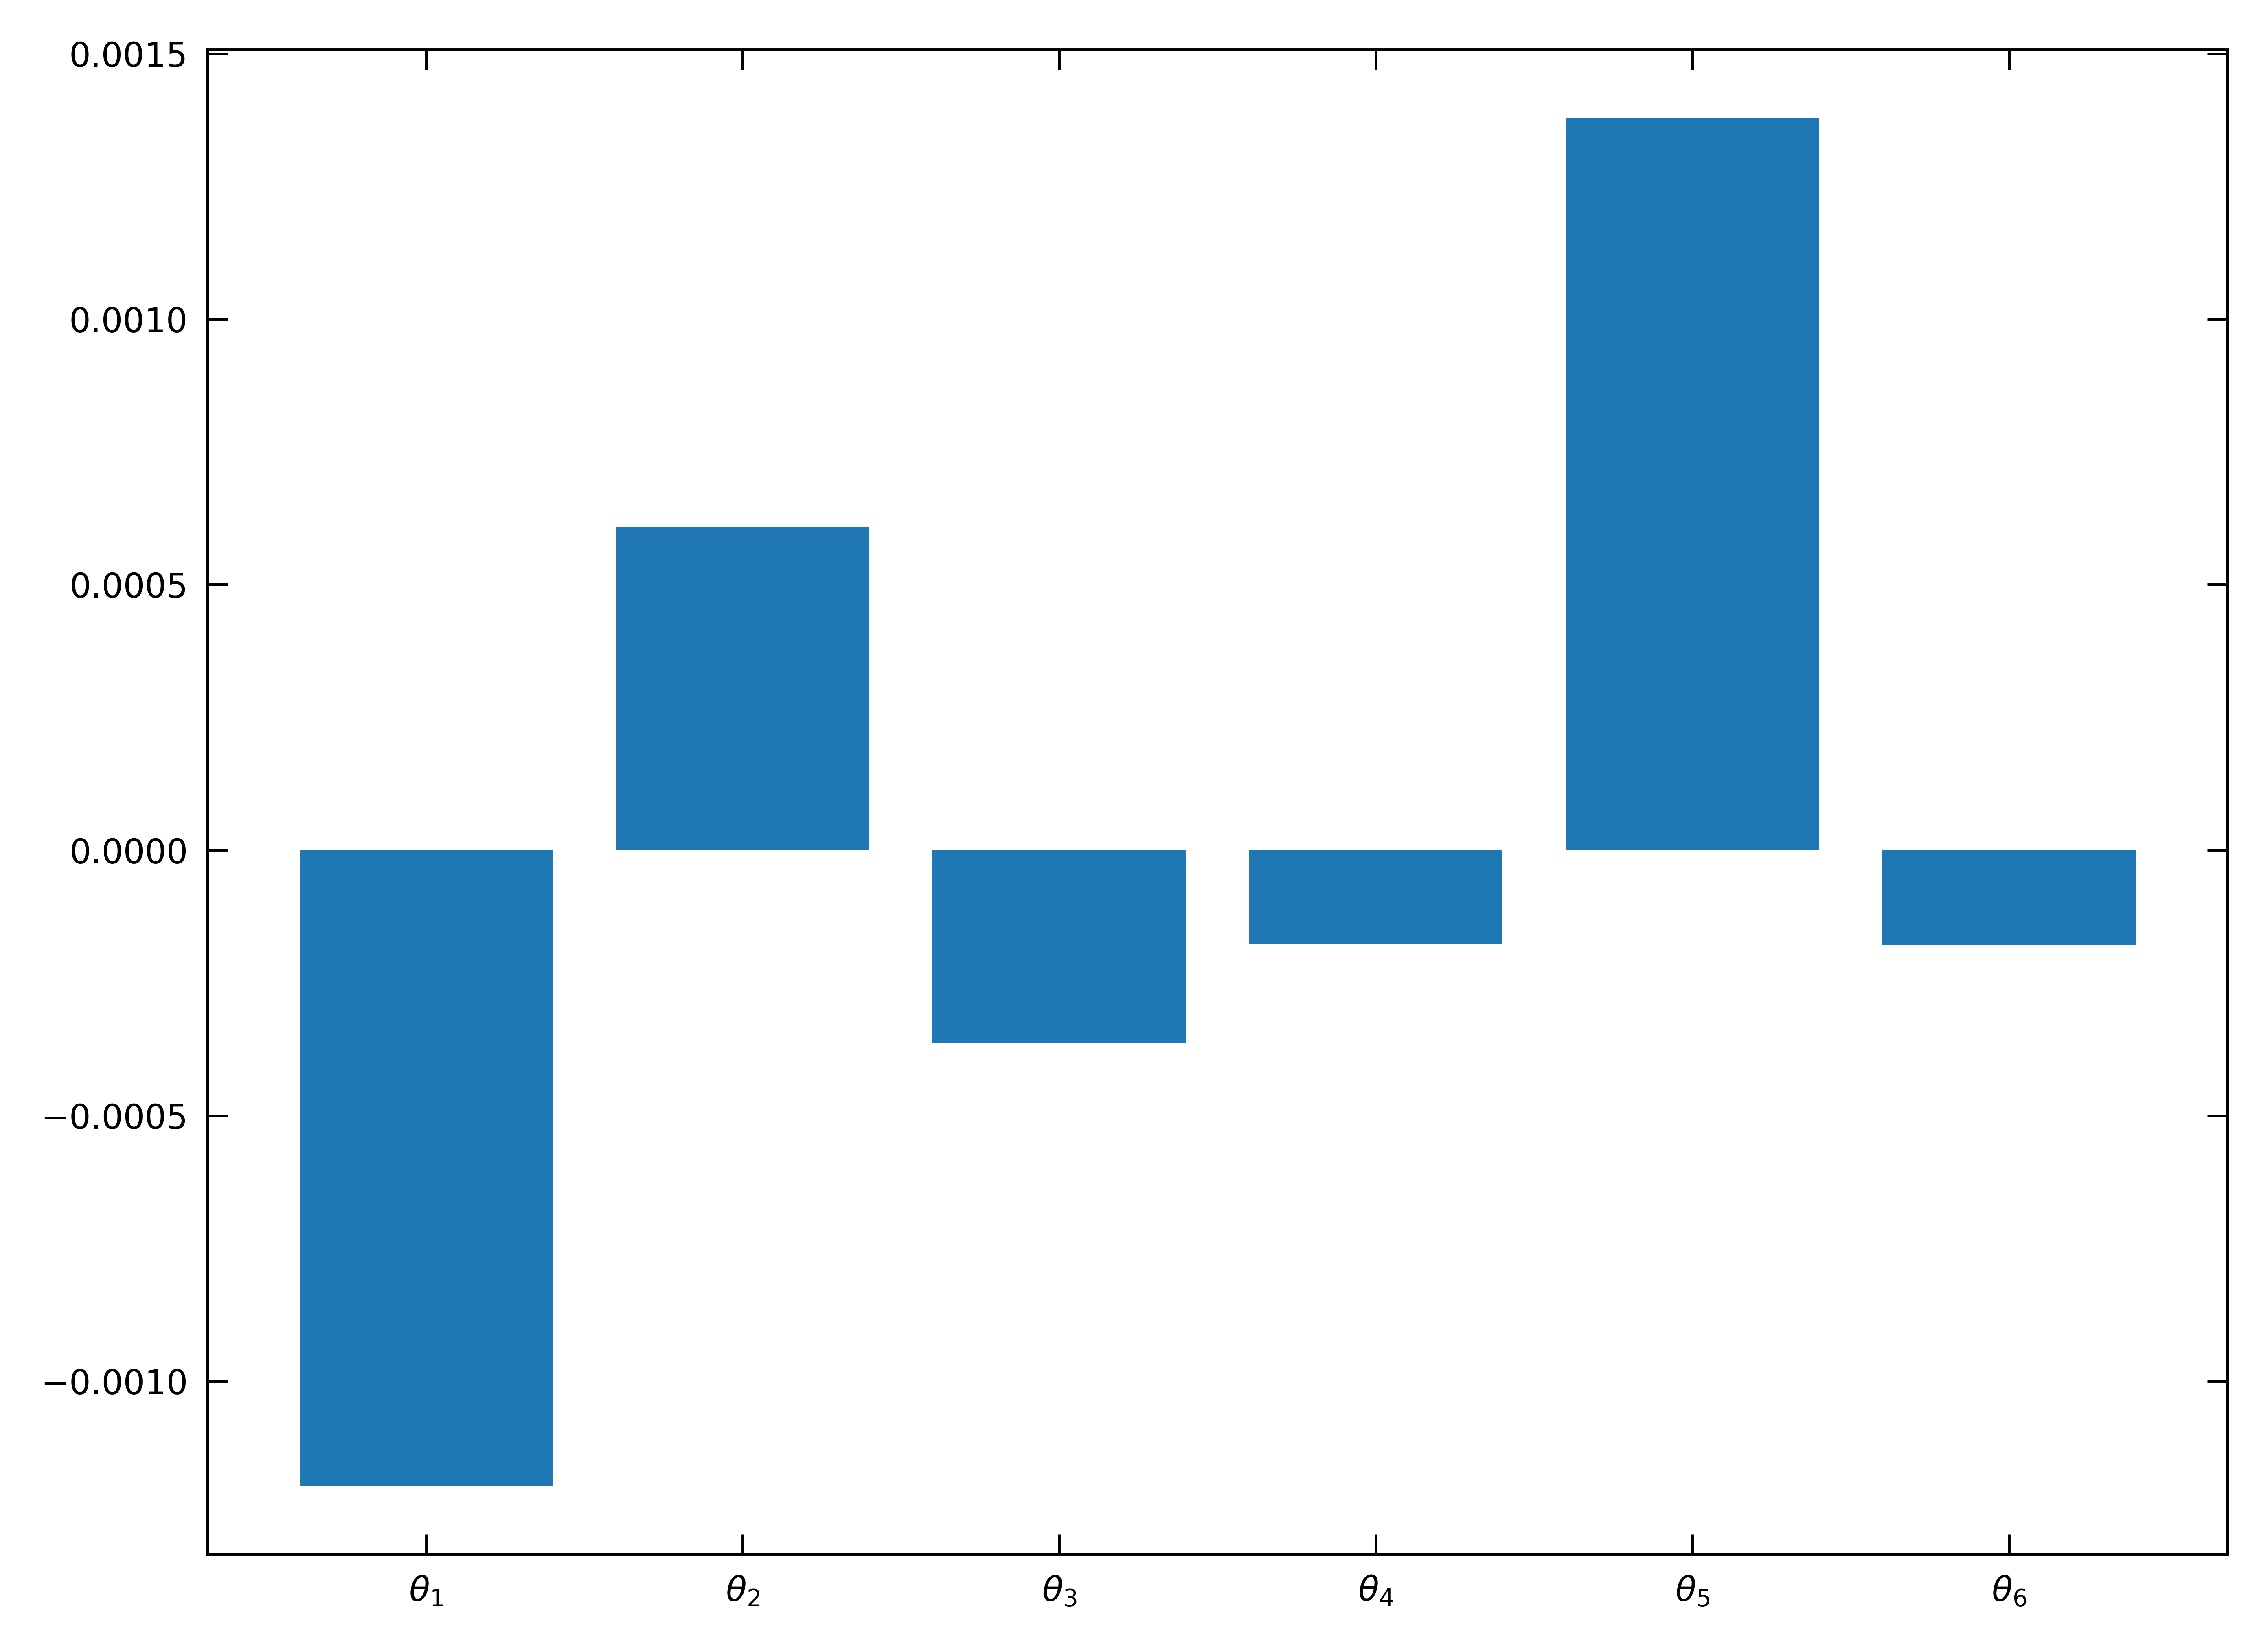

In [142]:
fig, ax = plt.subplots()

vars = [
    r'$\theta_1$', r'$\theta_2$', r'$\theta_3$', r'$\theta_4$', r'$\theta_5$',
    r'$\theta_6$'
]
shap_values = np.loadtxt('SHAP-NN.csv', delimiter=',')
ax.bar(vars, np.mean((shap_values), axis=0))
# ax.set(ylim=(0, 0.1))
plt.savefig('SHAP-NN.png')